# Predicting loan grades in Lending Club data set from features similar to those available in Regalii transaction data

The overall goal of this analysis was to determine the feasibility of assessing loan risk for Regalii users based on their bill payment history while using the service. The data available from Regalii were logs of each transaction, which included information about the user making the transaction, the transaction amount, the billing account toward which the transaction was being applied, the date of the transaction, and many other features. The first 3 zip code digits of each user were also available in separate data logs. 

From this transaction log, data was aggregated for each user to determine what features (variables) could be calculated on a per-user basis (see 'regalii_data' notebook). These features included the total number of transactions made, the average amount of each transaction, the number of months since the first bill was paid, the number of billing accounts the user has made payments towards, and several others. 

However, the transaction log data only contained information about payments made by users- there was no information about charges sent to users before payments occurred, meaning there was no way of telling if a user had paid a bill late or had missed payments. Thus there was no way of accurately measuring how financially disciplined a user was (i.e. Did they miss bills? Could whether they missed a bill be predicted from their past transaction history?). Relating back to the overall goal of the project, this financial discipline measure would be key in deciding if a user was at risk of defaulting on a loan. 

To bridge this gap, I turned to the publicly available Lending Club data set (https://www.lendingclub.com/info/download-data.action) for loans extended to Lending Club users between 2007-2012. This data contained both loan risk grades assigned to users and certain user features that were roughly similar to those that were available or could be calculated from the Regalii data, including:

- Number of total accounts (this meant credit accounts in the Lending Club data but is roughly equated to the number of billing accounts a user made payments on in the Regalii data)
- Months since earliest credit line (again, roughly equated to months since the earliest bill payment made by a Regalii user)
- Number of open accounts (approximated in the Regalii data by billing accounts towards which a user has made a payment in the last ~1 month)
- Revolving credit balance (approximated in Regalii data by total transaction amount in previous month)

Also included were features available to Regalii from other data sources (other than transaction logs) that were either privately or publicly accessible, or would be available if a loan was being offered to a user:

- First 3 zip code digits
- Number of missed bill payments (delinquencies) in last 2 years
- Total amount of late fees received on bills due
- Months since last missed (delinquent) bill payment
- Number of derogatory public records
- Purpose for loan
- Loan amount
- Number of credit inquiries in last 6 months
- Number of months since last public record
- Number of accounts on which the user is now delinquent
- Number of public record bankruptcies


Initially, these features were all used to try to predict the loan risk grade assigned to each Lending Club user. The purpose of this step was to use the assigned Lending Club loan risk grades as ground truths to see how feasible it was to correctly classify Lending Club users into risk categories using features similar to those available about Regalii users. Additionally, how important each feature was for accruate loan grade classification was also evaluated. This would give some idea to Regalii about how easily they could use currently available information to assign loan risks to users. 

As a next step, an expanded set of features from the Lending Club data were added to the model to determine whether their inclusion increased loan grade prediction accuracy. These features were chosen because they may be able to be gathered for Regalii users in the future if the company decides to pursue them. They included:

- Home ownership (e.g. whether a user rents, has a mortgage, outright owns a home, or otherwise)
- Employment
- Annual income
- Debt-to-income ratio (could be roughly equated by a ratio of bill payment amounts per month to income level for Regalii users) 
- Verification status (whether income was verified)

If any of these additional features were important in increasing loan grade classification accuracy, these were recommended as new user features that Regalii may be interested in obtaining. 


# Results summary

Results using initial group of features:
- 


The remainder of this notebook consists of the code that was used to obtain these results, including details about the Extra Trees classification model (from the scikit-learn Python library) used to predict loan grade classifications.

In [48]:
#Make sure any plots are shown inline in the notebook
%matplotlib inline

#import libraries
from __future__ import absolute_import, division, print_function
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.ensemble as ske
import sklearn.preprocessing as skp
import math
import sigopt
import seaborn as sb


In [49]:
#Load data set for accepted loans
loans = pd.read_csv('LoanStats3a.csv', header=1, index_col=0)

#Set options so that all columns can be displayed if needed
pd.options.display.max_columns = len(loans.columns)

In [50]:
#Remove last two rows that represent summary data
l = len(loans.index)
loans.drop(loans.index[[l-2,l-1]], inplace=True)
del l

In [52]:
#Keep only the columns that are to be explored for the model
loans = loans.loc[:,['home_ownership',
                     'emp_length',
                     'annual_inc',
                     'verification_status',
                     'purpose',
                     'earliest_cr_line',
#                      'inq_last_12m', #note that all values are Null for this feature; do not include
                     'inq_last_6mths',
                     'mths_since_last_record',
                     'open_acc',
                     'revol_bal',
                     'total_acc',
                     'acc_now_delinq',
                     'pub_rec_bankruptcies',
                     'delinq_2yrs',
                     'dti',
                     'loan_amnt',
                     'grade',
                     'mths_since_last_delinq',
                     'pub_rec',
                     'total_rec_late_fee',
                     'zip_code']]

#Check how many non-missing feature values each user has
nonnull_count = loans.count(axis=1)

#Drop users that have less than len(loans.columns)-1 features with values (turned out that no users had <20 of the 21 features present)
loans.drop(nonnull_count.index[nonnull_count.values < len(loans.columns)-1], inplace=True)
nonnull_count.drop(nonnull_count.index[nonnull_count.values < len(loans.columns)-1], inplace=True)

In [56]:
#For the remaining users with 0-1 missing features, show which features (set to NaN) are normally missing.
#Note that often it is "mths_since_last_record" and "mths_since_last_delinq"
sample11 = loans.loc[nonnull_count.values < len(loans.columns),:]
missing_feature_count = 100*sample11.count(axis=0)/len(sample11)
print('% of users with each feature among users missing 0-1 features:')
print(missing_feature_count)

% of users with each feature among users missing 0-1 features:
home_ownership            100.000000
emp_length                100.000000
annual_inc                100.000000
verification_status       100.000000
purpose                   100.000000
earliest_cr_line          100.000000
inq_last_6mths            100.000000
mths_since_last_record     16.447867
open_acc                  100.000000
revol_bal                 100.000000
total_acc                 100.000000
acc_now_delinq            100.000000
pub_rec_bankruptcies       91.649836
delinq_2yrs               100.000000
dti                       100.000000
loan_amnt                 100.000000
grade                     100.000000
mths_since_last_delinq     91.902297
pub_rec                   100.000000
total_rec_late_fee        100.000000
zip_code                  100.000000
dtype: float64


In [57]:
#Double check that 'delinq_2yrs' is 0 (as expected) for users whose have no value for 'mths_since_last_delinq' 
#or a value >24 months 
sample12 = loans[np.logical_or(loans.mths_since_last_delinq.isnull(), loans.mths_since_last_delinq > 24)]
print()
print('Check users who have "mths_since_last_delinq" value >24 months or None also','\n','all have 0 values for "delinq_2yrs" when summed across users:')
print(sample12.loc[:,['delinq_2yrs']].sum())


Check users who have "mths_since_last_delinq" value >24 months or None also 
 all have 0 values for "delinq_2yrs" when summed across users:
delinq_2yrs    0.0
dtype: float64


In [58]:
#Convert 'earliest_cr_line' feature to number of months since earliest credit line ('mths_since_earliest_cr_line')

#Add '20' or '19' in front of each year in data so pandas can correctly convert to Timestamp
dates = list(loans.loc[:,'earliest_cr_line'].values)
for i, date in enumerate(dates):
    if int(date[-2]) < 2:
        dates[i] = date[:-2] + '20' + date[-2:]
    elif int(date[-2]) >= 2:
        dates[i] = date[:-2] + '19' + date[-2:]

#Convert dates to number of months prior to June 2016
tdiff = pd.Timestamp('06-01-2016') - pd.to_datetime(pd.Series(dates))
tdiff = tdiff.astype('timedelta64[M]')

#Add 'mths_since_earliest_cr_line' columns in 'loans' and remove 'earliest_cr_line'
loans['mths_since_earliest_cr_line'] = tdiff.values
loans.drop('earliest_cr_line', axis=1, inplace=True)


In [59]:
loans.head()

,home_ownership,emp_length,annual_inc,verification_status,purpose,inq_last_6mths,mths_since_last_record,open_acc,revol_bal,total_acc,acc_now_delinq,pub_rec_bankruptcies,delinq_2yrs,dti,loan_amnt,grade,mths_since_last_delinq,pub_rec,total_rec_late_fee,zip_code,mths_since_earliest_cr_line
id,,,,,,,,,,,,,,,,,,,,,
1076863,RENT,10+ years,49200.0,Source Verified,other,1.0,NaN,10.0,5598.0,37.0,0.0,0.0,0.0,20.00,10000.0,C,35.0,0.0,16.97,917xx,243.0
1075358,RENT,1 year,80000.0,Source Verified,other,0.0,NaN,15.0,27783.0,38.0,0.0,0.0,0.0,17.94,3000.0,B,38.0,0.0,0.00,972xx,244.0
1065775,RENT,4 years,42000.0,Not Verified,home_improvement,2.0,NaN,14.0,24043.0,28.0,0.0,0.0,0.0,18.60,10000.0,C,61.0,0.0,0.00,921xx,212.0
1062474,MORTGAGE,1 year,84000.0,Verified,medical,0.0,NaN,4.0,0.0,14.0,0.0,0.0,2.0,18.44,6000.0,B,8.0,0.0,15.00,890xx,152.0
1069657,RENT,2 years,50004.0,Not Verified,other,0.0,NaN,14.0,4345.0,22.0,0.0,0.0,3.0,13.97,5000.0,D,20.0,0.0,0.00,150xx,152.0


In [60]:
#This cell will plot histograms of ALL features- only run if needed
'''
#Plot histograms of distributions of data in each remaining column 
#to make sure there are a variety of values in each column
columns = list(loans)
for i, column in enumerate(columns):
    plt.figure()
    if column not in list(loans.select_dtypes(include=['number'])):
        loans.loc[:,column].value_counts().plot(kind='bar', title=column)
    else:
        loans.loc[:,column].plot(kind='hist', title=column, bins=30)
    
del columns
'''

"\n#Plot histograms of distributions of data in each remaining column \n#to make sure there are a variety of values in each column\ncolumns = list(loans)\nfor i, column in enumerate(columns):\n    plt.figure()\n    if column not in list(loans.select_dtypes(include=['number'])):\n        loans.loc[:,column].value_counts().plot(kind='bar', title=column)\n    else:\n        loans.loc[:,column].plot(kind='hist', title=column, bins=30)\n    \ndel columns\n"

In [61]:
#Set the "mths_since_last_delinq" and "mths_since_last_record" to 12000 where
#they are currently NaN so that they aren't treated as missing data in the model
loans.loc[np.isnan(loans.mths_since_last_delinq),'mths_since_last_delinq'] = 1200
loans.loc[np.isnan(loans.mths_since_last_record),'mths_since_last_record'] = 1200

#Fill any NaNs in columns with missing values with values appropriate for each feature
loans = loans.fillna({'pub_rec_bankruptcies': -1})

In [62]:
#Shuffle row indices 
shuffled_index = list(loans.index)
np.random.shuffle(shuffled_index)

#Use first 10% of shuffled row indices to specify rows for a test set and the remaining 90% to specify 
#rows for a training set
split_ind = int(np.around(0.1*len(loans.index)))
all_feat = [ 'home_ownership',
             'emp_length',
             'annual_inc',
             'dti',
             'verification_status',
             'purpose',
             'mths_since_earliest_cr_line',
             'inq_last_6mths',
             'mths_since_last_record',
             'open_acc',
             'revol_bal',
             'total_acc',
             'acc_now_delinq',
             'pub_rec_bankruptcies',
             'delinq_2yrs',
             'loan_amnt',
             'grade',
             'mths_since_last_delinq',
             'pub_rec',
             'total_rec_late_fee',
             'zip_code']
test_set_all = loans.loc[shuffled_index[0:split_ind],all_feat]
train_set_all = loans.loc[shuffled_index[split_ind:],all_feat]

#Get subset of features corresponding to Regalii's limited feature set
limited_feat = [ 
             'purpose',
             'mths_since_earliest_cr_line',
             'inq_last_6mths',
             'mths_since_last_record',
             'open_acc',
             'revol_bal',
             'total_acc',
             'acc_now_delinq',
             'pub_rec_bankruptcies',
             'delinq_2yrs',
             'loan_amnt',
             'grade',
             'mths_since_last_delinq',
             'pub_rec',
             'total_rec_late_fee',
             'zip_code']
test_set_limited = loans.loc[shuffled_index[0:split_ind],limited_feat]

train_set_limited = loans.loc[shuffled_index[split_ind:],limited_feat]

#Separate all-feature data into arrays of features and labels with categorical variables transformed into 1-of-n coding 
#(ExtraTreesClassifier doesn't accept non-numerical data)
lb_labels = skp.LabelEncoder()
lb_labels.fit(loans.loc[:,'grade'].values)
test_labels_all = lb_labels.transform(test_set_all.loc[:,'grade'].values)
train_labels_all = lb_labels.transform(train_set_all.loc[:,'grade'].values)

columns = list(test_set_all)
test_features_all = np.empty((len(test_set_all.index),1))
train_features_all = np.empty((len(train_set_all.index),1))
lb_tmp = skp.LabelBinarizer()
for column in columns:
    if column != 'grade' and column not in list(test_set_all.select_dtypes(include=['number'])):
        lb_tmp.fit(loans.loc[:,column].values)
        test_features_all = np.concatenate((test_features_all, lb_tmp.transform(test_set_all.loc[:,column].values)), axis=1)
        train_features_all = np.concatenate((train_features_all, lb_tmp.transform(train_set_all.loc[:,column].values)), axis=1)
    elif column != 'grade' and column in list(test_set_all.select_dtypes(include=['number'])):
        tmp = test_set_all.loc[:,column].values
        test_features_all = np.concatenate((test_features_all, tmp.reshape((len(tmp),1))), axis=1)
        tmp = train_set_all.loc[:,column].values
        train_features_all = np.concatenate((train_features_all, tmp.reshape((len(tmp),1))), axis=1)


test_features_all = np.delete(test_features_all, 0, 1)
train_features_all = np.delete(train_features_all, 0, 1)

del lb_tmp, tmp

#Separate limited-feature data into arrays of features and labels with categorical variables transformed into 1-of-n coding 
#(ExtraTreesClassifier doesn't accept non-numerical data)
test_labels_limited = lb_labels.transform(test_set_limited.loc[:,'grade'].values)
train_labels_limited = lb_labels.transform(train_set_limited.loc[:,'grade'].values)

columns = list(test_set_limited)
test_features_limited = np.empty((len(test_set_limited.index),1))
train_features_limited = np.empty((len(train_set_limited.index),1))
lb_tmp = skp.LabelBinarizer()
for column in columns:
    if column != 'grade' and column not in list(test_set_limited.select_dtypes(include=['number'])):
        lb_tmp.fit(loans.loc[:,column].values)
        test_features_limited = np.concatenate((test_features_limited, lb_tmp.transform(test_set_limited.loc[:,column].values)), axis=1)
        train_features_limited = np.concatenate((train_features_limited, lb_tmp.transform(train_set_limited.loc[:,column].values)), axis=1)
    elif column != 'grade' and column in list(test_set_limited.select_dtypes(include=['number'])):
        tmp = test_set_limited.loc[:,column].values
        test_features_limited = np.concatenate((test_features_limited, tmp.reshape((len(tmp),1))), axis=1)
        tmp = train_set_limited.loc[:,column].values
        train_features_limited = np.concatenate((train_features_limited, tmp.reshape((len(tmp),1))), axis=1)


test_features_limited = np.delete(test_features_limited, 0, 1)
train_features_limited = np.delete(train_features_limited, 0, 1)
  
del shuffled_index, split_ind, tmp, columns, lb_tmp

In [63]:
#Fit extra trees classifier to all-feature data
extra_all = ske.ExtraTreesClassifier(n_estimators=50, 
                                    criterion='gini',
                                    max_features=None,
                                    class_weight='balanced_subsample',
                                    bootstrap=True,
                                    oob_score=True
                                   )
cv_scores_all = sk.cross_validation.cross_val_score(extra_all, train_features_all, train_labels_all, cv=5)
print('Cross-validation scores (all features): ', cv_scores_all)
extra_all.fit(train_features_all, train_labels_all)

Cross-validation scores (all features):  [ 0.30594808  0.31502795  0.30921053  0.31435155  0.32455563]


ExtraTreesClassifier(bootstrap=True, class_weight='balanced_subsample',
           criterion='gini', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [14]:
'''
#Use SigOpt to try to optimize parameters

conn = sigopt.Connection(client_token="LKJIIUJAOZIXDRGWSMLJCTTKOWLCCKRJYBOEVZTKYJVOOXRN")

# Create an experiment to find hyperparameters for Extra Trees with All features
experiment = conn.experiments().create(
  name="Extra Trees Optimization All Features",
  parameters=[
    {'name': 'n_est', 'bounds': {'max': 200, 'min': 30}, 'type': 'int'},
    {'name': 'crit', 'categorical_values': [{'enum_index': 1, 'name': 'gini', 'object': 'categorical_value'}, {'enum_index': 2, 'name': 'entropy', 'object': 'categorical_value'}], 'type': 'categorical'},
    {'name': 'max_feat', 'bounds': {'max': len(all_feat), 'min': int(np.around(np.sqrt(len(all_feat))))}, 'type': 'int'},
    {'name': 'min_samp_split', 'bounds': {'max': 20, 'min': 1}, 'type': 'int'},
    {'name': 'min_samp_leaf', 'bounds': {'max': 20, 'min': 1}, 'type': 'int'},
  ],
)
print("Created an experiment with id {0}.".format(experiment.id))

# Receive a suggestion from SigOpt and evaluate
def evaluate_metric(n_est, crit, max_feat, min_samp_split, min_samp_leaf, trfeatures, trlabels):
    opt_extra = ske.ExtraTreesClassifier(n_estimators=n_est, 
                                          criterion=crit, 
                                          max_features=max_feat, 
                                          min_samples_split=min_samp_split, 
                                          min_samples_leaf=min_samp_leaf, 
                                          class_weight='balanced_subsample',
                                          bootstrap=True,
                                          oob_score=True
                                         )
    opt_extra.fit(trfeatures, trlabels)

    return (opt_extra.oob_score_)

# In a loop: receive a suggestion, evaluate metric, then report an observation
for it in range(100):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    n_est = suggestion.assignments['n_est']
    crit = suggestion.assignments['crit']
    max_feat = suggestion.assignments['max_feat']
    min_samp_split = suggestion.assignments['min_samp_split']
    min_samp_leaf = suggestion.assignments['min_samp_leaf']
    
    print("Received a suggestion with n_est={n_est}, crit={crit}, max_feat={max_feat}, min_samp_split={min_samp_split}, min_samp_leaf={min_samp_leaf}.".format(n_est=n_est, crit=crit, max_feat=max_feat, min_samp_split=min_samp_split, min_samp_leaf=min_samp_leaf))
    value = evaluate_metric(n_est, crit, max_feat, min_samp_split, min_samp_leaf, train_features_all, train_labels_all)
    print("Iteration {0} complete.".format(it))
    print("The function evaluated to {0} using these parameters.".format(value))
    conn.experiments(experiment.id).observations().create(
    suggestion=suggestion.id,
    value=value,
  )
  '''

'\n#Use SigOpt to try to optimize parameters\n\nconn = sigopt.Connection(client_token="LKJIIUJAOZIXDRGWSMLJCTTKOWLCCKRJYBOEVZTKYJVOOXRN")\n\n# Create an experiment to find hyperparameters for Extra Trees with All features\nexperiment = conn.experiments().create(\n  name="Extra Trees Optimization All Features",\n  parameters=[\n    {\'name\': \'n_est\', \'bounds\': {\'max\': 200, \'min\': 30}, \'type\': \'int\'},\n    {\'name\': \'crit\', \'categorical_values\': [{\'enum_index\': 1, \'name\': \'gini\', \'object\': \'categorical_value\'}, {\'enum_index\': 2, \'name\': \'entropy\', \'object\': \'categorical_value\'}], \'type\': \'categorical\'},\n    {\'name\': \'max_feat\', \'bounds\': {\'max\': len(all_feat), \'min\': int(np.around(np.sqrt(len(all_feat))))}, \'type\': \'int\'},\n    {\'name\': \'min_samp_split\', \'bounds\': {\'max\': 20, \'min\': 1}, \'type\': \'int\'},\n    {\'name\': \'min_samp_leaf\', \'bounds\': {\'max\': 20, \'min\': 1}, \'type\': \'int\'},\n  ],\n)\nprint("Create

Proportion of correct test predictions:  0.389084921195
Proportion of train data in most common class:  0.291752712064


<Container object of 7 artists>

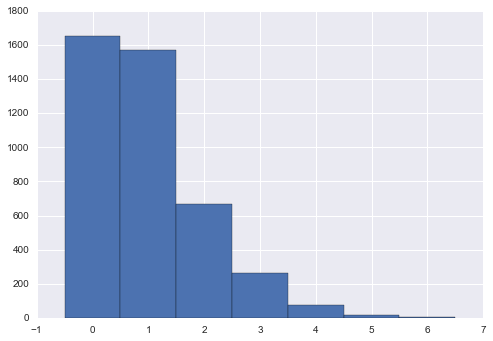

In [15]:
#Use classifier to return score and output predicted test labels
print('Proportion of correct test predictions: ',extra_all.score(test_features_all, test_labels_all))
predicted_labels_all = extra_all.predict(test_features_all)

#Instead of a score based on correct/incorrect class assignment, see how 
#close class assignment was to actual class
test_grade_all = lb_labels.inverse_transform(test_labels_all)
predicted_grade_all = lb_labels.inverse_transform(predicted_labels_all)
train_grade_all = lb_labels.inverse_transform(train_labels_all)

grades = np.unique(loans.loc[:,'grade'].values)

for i, grade in enumerate(grades):
    np.copyto(test_grade_all, i*np.ones(test_grade_all.shape), where=test_grade_all==grade)
    np.copyto(predicted_grade_all, i*np.ones(predicted_grade_all.shape), where=predicted_grade_all==grade)
    np.copyto(train_grade_all, i*np.ones(train_grade_all.shape), where=train_grade_all==grade)

test_grade_all = test_grade_all.astype('int')
predicted_grade_all = predicted_grade_all.astype('int')
train_grade_all = train_grade_all.astype('int')

#Show what the predicted classification accuracy would be if just chose most frequent class in 
#the train data as the predicted classification
grade_counts_all,_ = np.histogram(train_grade_all, bins=np.arange(-0.5,len(grades)+0.5))
print('Proportion of train data in most common class: ', max(grade_counts_all/grade_counts_all.sum()))

#Count how many test samples were at what distance from the correct class and plot histogram
prediction_distances_all = np.fabs(test_grade_all-predicted_grade_all)
distance_counts_all, bin_edges = np.histogram(prediction_distances_all, bins=np.arange(-0.5,len(grades)+0.5))
plt.bar(bin_edges[:len(distance_counts_all)], distance_counts_all, width=1)

In [16]:
#Check that the model did not just output the most common class in the training data to achieve the given 
#accuracy level (proportion of classes in train set and predicted label set should be similar). Also, 
#calculate what the model accuracy would have been if it just guessed labels according to training class proportions.
print('Train set class proportions:')
random_guess_accuracy = 0
class_proportions = np.zeros((1,len(distance_counts_all)))
for i, grade in enumerate(grades):
    class_proportions[0,i] = len([x for x in train_grade_all if x == i])/len(train_grade_all)
    print(grade, ': ', class_proportions[0,i])
    random_guess_accuracy += class_proportions[0,i]*class_proportions[0,i]

print()    

print('Predicted label class proportions:')
for i, grade in enumerate(grades):
    print(grade, ': ', len([x for x in predicted_grade_all if x == i])/len(predicted_grade_all))
    
print()
print('Accuracy if randomly guessed according to class frequency: ', random_guess_accuracy)

#Determine the error distance counts that would occur if class labels were guessed at random at the
#frequency with which each label appeared in the training data
guess_joint_prob = np.tile(class_proportions, (len(distance_counts_all),1))*np.tile(class_proportions.T, len(distance_counts_all))
random_guess_distance_counts = np.zeros(len(distance_counts_all))
for i in range(len(grades)):
    for j in range(len(distance_counts_all)):
        if i-j >= 0:
            random_guess_distance_counts[i-j] += guess_joint_prob[i,j]*len(test_grade_all)
        elif j-i > 0:
            random_guess_distance_counts[j-i] += guess_joint_prob[i,j]*len(test_grade_all)

#Determine the error distance counts that would occur if the most frequent training class label was guessed 
#in every test case
frequent_class_guess_distance_counts = np.zeros(len(distance_counts_all))
max_freq_id = np.argmax(class_proportions)
for i, grade in enumerate(grades):
    dist = np.fabs(i - max_freq_id)
    frequent_class_guess_distance_counts[dist] += class_proportions[0][i]*len(test_grade_all)

del grade, i, dist, max_freq_id

Train set class proportions:
A :  0.240334596785
B :  0.291752712064
C :  0.205620180369
D :  0.140948895569
E :  0.0788132270291
F :  0.0304012547379
G :  0.0121291334466

Predicted label class proportions:
A :  0.280639849447
B :  0.358974358974
C :  0.212185368149
D :  0.0846859562456
E :  0.0465772759351
F :  0.0138790872736
G :  0.00305810397554

Accuracy if randomly guessed according to class frequency:  0.212309490068


/Users/amar/anaconda/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [17]:
#Fit extra trees classifier to limited-feature data
extra_limited = ske.ExtraTreesClassifier(n_estimators=50, 
                                    criterion='gini',
                                    max_features=None,
                                    class_weight='balanced_subsample',
                                    bootstrap=True,
                                    oob_score=True
                                   )

cv_scores_limited = sk.cross_validation.cross_val_score(extra_limited, train_features_limited, train_labels_limited, cv=5)
print('Cross-validation scores (limited features): ', cv_scores_limited)
extra_limited.fit(train_features_limited, train_labels_limited)

Cross-validation scores (limited features):  [ 0.366867    0.35624673  0.35903803  0.36836601  0.36532427]


ExtraTreesClassifier(bootstrap=True, class_weight='balanced_subsample',
           criterion='gini', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

Proportion of correct test predictions:  0.368148670901
Proportion of test data in most common class:  0.290755116443


<Container object of 7 artists>

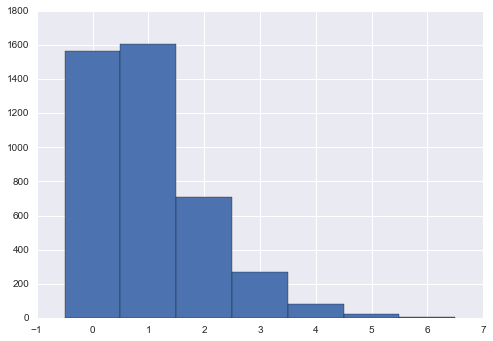

In [40]:
#Use classifier to return score and output predicted test labels
print('Proportion of correct test predictions: ',extra_limited.score(test_features_limited, test_labels_limited))
predicted_labels_limited = extra_limited.predict(test_features_limited)

#Instead of a score based on correct/incorrect class assignment, see how 
#close class assignment was to actual class
test_grade_limited = lb_labels.inverse_transform(test_labels_limited)
predicted_grade_limited = lb_labels.inverse_transform(predicted_labels_limited)

grades = np.unique(loans.loc[:,'grade'].values)

for i, grade in enumerate(grades):
    np.copyto(test_grade_limited, i*np.ones(test_grade_limited.shape), where=test_grade_limited==grade)
    
for i, grade in enumerate(grades):
    np.copyto(predicted_grade_limited, i*np.ones(predicted_grade_limited.shape), where=predicted_grade_limited==grade)

test_grade_limited = test_grade_limited.astype('int')
predicted_grade_limited = predicted_grade_limited.astype('int')

#Show what the predicted classification accuracy would be if just chose most frequent class in 
#the test data as the predicted classification
grade_counts_limited,_ = np.histogram(test_grade_limited, bins=np.arange(-0.5,len(grades)+0.5))
print('Proportion of test data in most common class: ', max(grade_counts_limited/grade_counts_limited.sum()))

#Count how many test samples were at what distance from the correct class and plot histogram
prediction_distances_limited = np.fabs(test_grade_limited-predicted_grade_limited)
distance_counts_limited, bin_edges = np.histogram(prediction_distances_limited, bins=np.arange(-0.5,len(grades)+0.5))
plt.bar(bin_edges[:len(distance_counts_limited)], distance_counts_limited, width=1)

/Users/amar/anaconda/envs/my_projects_env/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Users/amar/anaconda/envs/my_projects_env/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


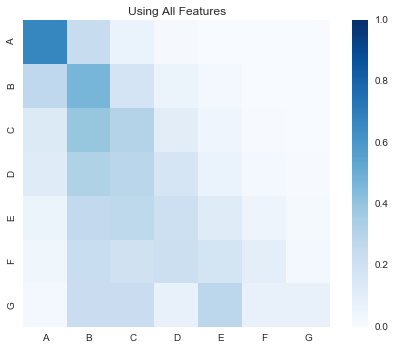

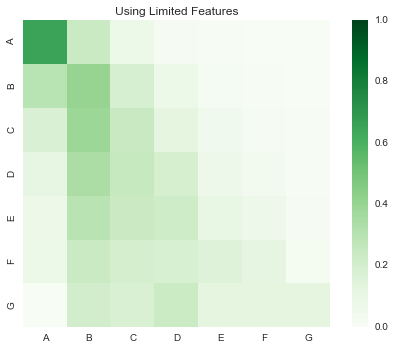

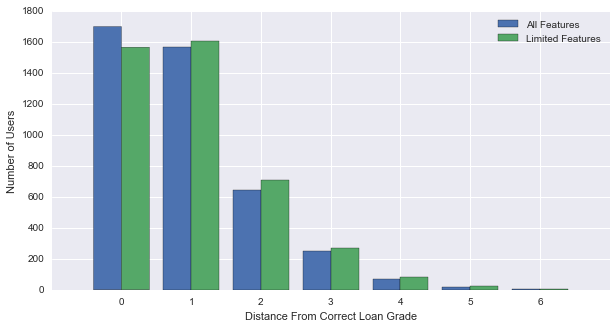

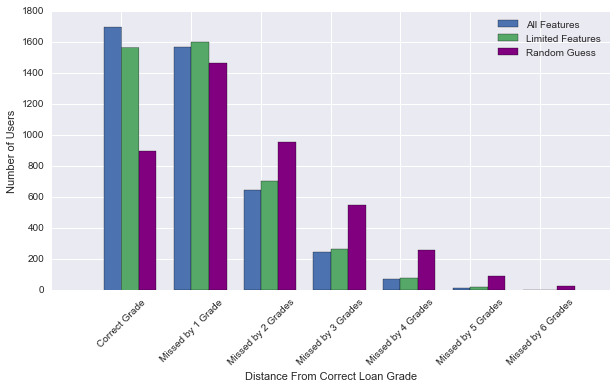

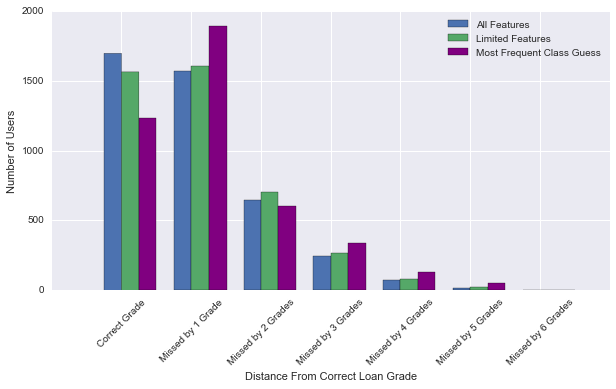

In [41]:
#Compare predicted classifications errors between All and Limited models

#Confusion matrices
test_classes_all = lb_labels.inverse_transform(test_labels_all)
predicted_classes_all = lb_labels.inverse_transform(predicted_labels_all)
cf = sk.metrics.confusion_matrix(test_classes_all.tolist(), predicted_classes_all.tolist())
tmp = np.tile(np.sum(cf, axis=1), (cf.shape[1],1)).T
confusion_matrix_all = cf/tmp

fig1 = plt.figure()
sb.heatmap(confusion_matrix_all, vmin=0, vmax=1, square=True, cmap='Blues', xticklabels=np.unique(test_classes_all.tolist()), yticklabels=np.unique(test_classes_all.tolist()))
plt.title('Using All Features')

test_classes_limited = lb_labels.inverse_transform(test_labels_limited)
predicted_classes_limited = lb_labels.inverse_transform(predicted_labels_limited)
cf = sk.metrics.confusion_matrix(test_classes_limited.tolist(), predicted_classes_limited.tolist())
tmp = np.tile(np.sum(cf, axis=1), (cf.shape[1],1)).T
confusion_matrix_limited = cf/tmp

fig2 = plt.figure()
sb.heatmap(confusion_matrix_limited, vmin=0, vmax=1, square=True, cmap='Greens', xticklabels=np.unique(test_classes_limited.tolist()), yticklabels=np.unique(test_classes_limited.tolist()))
plt.title('Using Limited Features')

#Histogram of distance from the correct class
d = (prediction_distances_all, prediction_distances_limited)

fig3, ax = plt.subplots(figsize=(10,5))
plt.hist(d, bins=np.arange(-0.5,7.5))
plt.xticks(range(len(np.unique(test_classes_all.tolist()))))
plt.xlabel('Distance From Correct Loan Grade')
plt.ylabel('Number of Users')
plt.legend(['All Features', 'Limited Features'], loc='upper right')

#Histogram of distance from the correct class plus the predicted count of each distance if class 
#predictions were guessed at random based on training class frequencies
d = (prediction_distances_all, prediction_distances_limited)

fig4, ax = plt.subplots(figsize=(10,5))
plt.hist(d, bins=np.arange(-0.5,7.5), rwidth=0.5)
plt.bar(np.array([0.25, 0.26, 0.25, 0.25, 0.25, 0.25, 0.25])+range(len(distance_counts_all)), random_guess_distance_counts, width=0.25, color='Purple')
plt.xticks(range(len(np.unique(test_classes_all.tolist()))), ['Correct Grade', 'Missed by 1 Grade', 'Missed by 2 Grades', 
                                                             'Missed by 3 Grades', 'Missed by 4 Grades', 
                                                              'Missed by 5 Grades', 'Missed by 6 Grades'], rotation=45)
plt.xlabel('Distance From Correct Loan Grade')
plt.ylabel('Number of Users')
plt.legend(['All Features', 'Limited Features', 'Random Guess'], loc='upper right')

#Histogram of distance from the correct class plus the predicted count of each distance if most 
#frequent class in training data was always chosen
d = (prediction_distances_all, prediction_distances_limited)

fig5, ax = plt.subplots(figsize=(10,5))
plt.hist(d, bins=np.arange(-0.5,7.5), rwidth=0.5)
plt.bar(np.array([0.25, 0.26, 0.25, 0.25, 0.25, 0.25, 0.25])+range(len(distance_counts_all)), frequent_class_guess_distance_counts, width=0.25, color='Purple')
plt.xticks(range(len(np.unique(test_classes_all.tolist()))), ['Correct Grade', 'Missed by 1 Grade', 'Missed by 2 Grades', 
                                                             'Missed by 3 Grades', 'Missed by 4 Grades', 
                                                              'Missed by 5 Grades', 'Missed by 6 Grades'], rotation=45)
plt.xlabel('Distance From Correct Loan Grade')
plt.ylabel('Number of Users')
plt.legend(['All Features', 'Limited Features', 'Most Frequent Class Guess'], loc='upper right')

del tmp, d, cf

In [83]:
ct = 0
extra_all_importances = np.zeros(len(all_feat))
tmp_importances = extra_all.feature_importances_
for i, column in enumerate(all_feat):
    if column != 'grade' and column in all_feat:
        if column != 'grade' and column not in train_set_all.select_dtypes(include=['number']):
            extra_all_importances[i] = np.sum(tmp_importances[ct:len(train_set_all.loc[:,column].unique())])
            ct += len(train_set_all.loc[:,column].unique())
        elif column != 'grade' and column in train_set_all.select_dtypes(include=['number']):
            extra_all_importances[i] = tmp_importances[ct]
            ct += 1

ct = 0
extra_limited_importances = np.zeros(len(all_feat))
tmp_importances = extra_limited.feature_importances_
for i, column in enumerate(all_feat):
    if column != 'grade' and column in limited_feat:
        if column != 'grade' and column not in train_set_limited.select_dtypes(include=['number']):
            extra_limited_importances[i] = np.sum(tmp_importances[ct:len(train_set_limited.loc[:,column].unique())])
            ct += len(train_set_limited.loc[:,column].unique())
        elif column != 'grade' and column in train_set_limited.select_dtypes(include=['number']):
            extra_limited_importances[i] = tmp_importances[ct]
        ct += 1

print(extra_all_importances)
print(extra_limited_importances)

del tmp_importances, ct

[  2.72402038e-02   6.24278255e-02   2.65446274e-02   0.00000000e+00
   0.00000000e+00   3.93575634e-02   3.65469709e-02   8.20107392e-03
   3.77774162e-02   3.08242162e-02   3.41900114e-02   2.74391309e-02
   7.56304709e-05   5.01907368e-03   8.42223283e-03   4.25496635e-02
   5.87411671e-02   0.00000000e+00   2.84542192e-02   3.61169614e-03
   1.07122693e-02   3.54871729e-01]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   8.54337604e-02   6.12564047e-02   0.00000000e+00   0.00000000e+00
   5.58115329e-02   5.36833684e-02   5.07061284e-02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   7.50880613e-02   0.00000000e+00
   3.59537215e-02   0.00000000e+00   1.07490309e-02   1.44014362e-02
   1.08378816e-05   5.32091603e-01]


In [84]:
print(np.cumsum(distance_counts_all))
print(np.cumsum(distance_counts_limited))

[1698 3267 3913 4162 4232 4249 4251]
[1565 3169 3875 4144 4225 4248 4251]


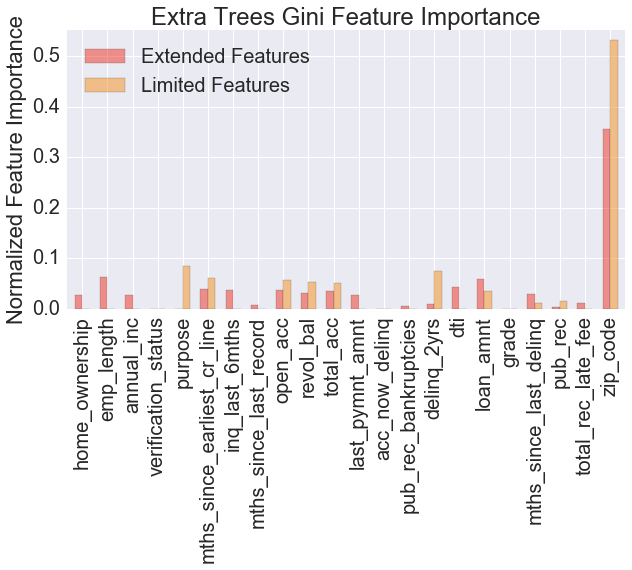

In [85]:
sb.set(font_scale=2)
d = {'All': extra_all_importances, 'Limited': extra_limited_importances}
df = pd.DataFrame(d)

# Setting the positions and width for the bars
pos = list(range(len(df['All'])))
width = 0.3

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with All feature importance data,
# in position pos,
plt.bar(pos, df['All'], width, alpha=0.5, color='#EE3224')

# Create a bar with Limited feature importance data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], df['Limited'], width, alpha=0.5, color='#F78F1E')

# Set the y axis label
ax.set_ylabel('Normalized Feature Importance')

# Set the chart's title
ax.set_title('Extra Trees Gini Feature Importance')

# Set the position of the x ticks
ax.set_xticks([p + width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(list(all_feat), rotation=90)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*3)
plt.ylim([0, max(max(df['All']),max(df['Limited']))+0.02] )

# Adding the legend and showing the plot
plt.legend(['Extended Features', 'Limited Features'], loc='upper left')

del d, df, pos, width

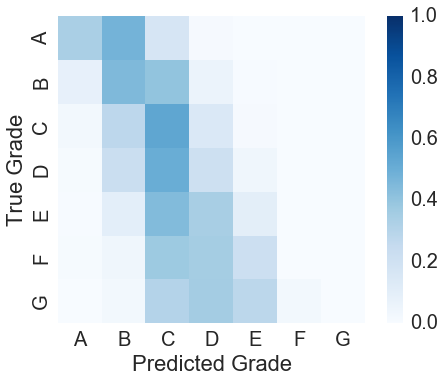

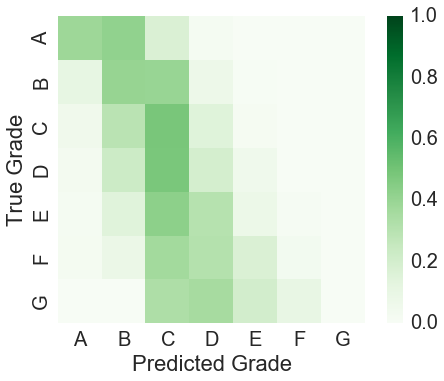

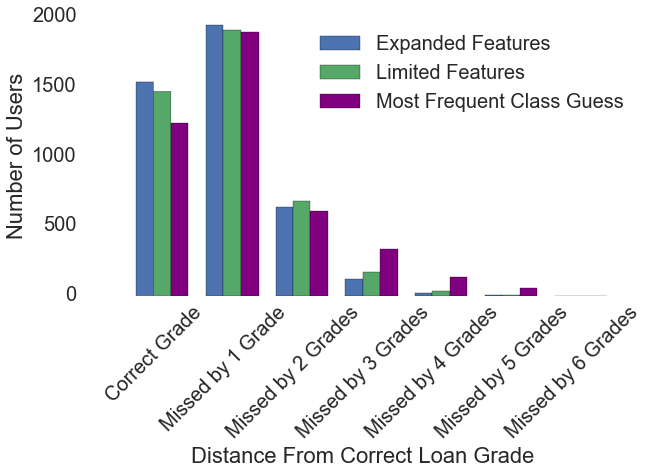

In [60]:
#Calculate classes by weighting the predicted probability of each class 
#(instead of the class with the highest probability)
class_prob_all = extra_all.predict_proba(test_features_all)
weighted_labels_all = np.zeros((np.shape(class_prob_all)[0]))
class_labels = range(np.shape(class_prob_all)[1])
for i, sample in enumerate(class_prob_all):
    weighted_labels_all[i] = np.round(np.sum(sample*class_labels))
weighted_labels_all = weighted_labels_all.astype(int, copy=False)

class_prob_limited = extra_limited.predict_proba(test_features_limited)
weighted_labels_limited = np.zeros((np.shape(class_prob_limited)[0]))
class_labels = range(np.shape(class_prob_limited)[1])
for i, sample in enumerate(class_prob_limited):
    weighted_labels_limited[i] = np.round(np.sum(sample*class_labels))
weighted_labels_limited = weighted_labels_limited.astype(int, copy=False)

del class_labels

#Confusion matrices
sb.set(font_scale=2)

# fig1 = plt.figure(frameon=False)
# sb.heatmap(confusion_matrix_all, vmin=0, vmax=1, square=True, cmap='Blues', xticklabels=np.unique(grades.tolist()), yticklabels=np.unique(grades.tolist()))
# plt.title('Using All Features: Max Probability Class Assignment')

cf = sk.metrics.confusion_matrix(test_labels_all.tolist(), weighted_labels_all.tolist())
tmp = np.tile(np.sum(cf, axis=1), (cf.shape[1],1)).T
confusion_matrix_weighted_all = cf/tmp

fig2 = plt.figure(frameon=False)
sb.heatmap(confusion_matrix_weighted_all, vmin=0, vmax=1, square=True, cmap='Blues', xticklabels=np.unique(grades.tolist()), yticklabels=np.unique(grades.tolist()))
# plt.title('Using All Features: Probability-Weighted Class Assignment')
plt.xlabel('Predicted Grade')
plt.ylabel('True Grade')

# fig3 = plt.figure(frameon=False)
# sb.heatmap(confusion_matrix_limited, vmin=0, vmax=1, square=True, cmap='Greens', xticklabels=np.unique(grades.tolist()), yticklabels=np.unique(grades.tolist()))
# plt.title('Using Limited Features: Max Probability Class Assignment')

cf = sk.metrics.confusion_matrix(test_labels_limited.tolist(), weighted_labels_limited.tolist())
tmp = np.tile(np.sum(cf, axis=1), (cf.shape[1],1)).T
confusion_matrix_weighted_limited = cf/tmp

fig4 = plt.figure(frameon=False)
sb.heatmap(confusion_matrix_weighted_limited, vmin=0, vmax=1, square=True, cmap='Greens', xticklabels=np.unique(grades.tolist()), yticklabels=np.unique(grades.tolist()))
# plt.title('Using Limited Features: Probability-Weighted Class Assignment')
plt.xlabel('Predicted Grade')
plt.ylabel('True Grade')

#Count how many test samples were at what distance from the correct class 
weighted_distances_all = np.fabs(test_grade_all-weighted_labels_all)
weighted_distance_counts_all, bin_edges = np.histogram(weighted_distances_all, bins=np.arange(-0.5,len(grades)+0.5))

weighted_distances_limited = np.fabs(test_grade_limited-weighted_labels_limited)
weighted_distance_counts_limited, bin_edges = np.histogram(weighted_distances_limited, bins=np.arange(-0.5,len(grades)+0.5))

#Histograms of distance from the correct class plus the predicted count of each distance if most 
#frequent class in training data was always chosen
d = (weighted_distances_all, weighted_distances_limited)

# fig5, ax = plt.subplots(figsize=(10,5))
# plt.bar(np.array([0.25, 0.26, 0.25, 0.25, 0.25, 0.25, 0.25])+range(len(distance_counts_all)), frequent_class_guess_distance_counts, width=0.25, color='Purple')
# plt.xticks(range(len(np.unique(test_classes_all.tolist()))), ['Correct Grade', 'Missed by 1 Grade', 'Missed by 2 Grades', 
#                                                              'Missed by 3 Grades', 'Missed by 4 Grades', 
#                                                               'Missed by 5 Grades', 'Missed by 6 Grades'], rotation=45)
# ax.patch.set_facecolor('none')
# plt.xlabel('Distance From Correct Loan Grade')
# plt.ylabel('Number of Users')
# plt.legend(['Most Frequent Class Guess'], loc='upper right')


# fig6, ax = plt.subplots(figsize=(10,5))
# plt.hist((weighted_distances_all, [0]), bins=np.arange(-0.5,7.5), rwidth=0.5)
# plt.bar(np.array([0.25, 0.26, 0.25, 0.25, 0.25, 0.25, 0.25])+range(len(distance_counts_all)), frequent_class_guess_distance_counts, width=0.25, color='Purple')
# plt.xticks(range(len(np.unique(test_classes_all.tolist()))), ['Correct Grade', 'Missed by 1 Grade', 'Missed by 2 Grades', 
#                                                              'Missed by 3 Grades', 'Missed by 4 Grades', 
#                                                               'Missed by 5 Grades', 'Missed by 6 Grades'], rotation=45)
# ax.patch.set_facecolor('none')
# plt.xlabel('Distance From Correct Loan Grade')
# plt.ylabel('Number of Users')
# plt.legend(['All Features - Probability-Weighted Class Assignment', 'Limited Features - Probability-Weighted Class Assignment', 'Most Frequent Class Guess'], loc='upper right')

fig7, ax = plt.subplots(figsize=(10,5))
plt.hist(d, bins=np.arange(-0.5,7.5), rwidth=0.5)
plt.bar(np.array([0.25, 0.26, 0.25, 0.25, 0.25, 0.25, 0.25])+range(len(distance_counts_all)), frequent_class_guess_distance_counts, width=0.25, color='Purple')
plt.xticks(range(len(np.unique(test_classes_all.tolist()))), ['Correct Grade', 'Missed by 1 Grade', 'Missed by 2 Grades', 
                                                             'Missed by 3 Grades', 'Missed by 4 Grades', 
                                                              'Missed by 5 Grades', 'Missed by 6 Grades'], rotation=45)
ax.patch.set_facecolor('none')
plt.xlabel('Distance From Correct Loan Grade')
plt.ylabel('Number of Users')
# plt.legend(['Expanded Features - Probability-Weighted Class Assignment', 'Limited Features - Probability-Weighted Class Assignment', 'Most Frequent Class Guess'], loc='upper right')
plt.legend(['Expanded Features', 'Limited Features', 'Most Frequent Class Guess'], loc='upper right')

del tmp, d, cf

In [46]:
print(prediction_distances_all.mean())
print(weighted_distances_all.mean())
print(prediction_distances_limited.mean())
print(weighted_distances_limited.mean())
print(np.sum(frequent_class_guess_distance_counts*range(len(grades)))/np.sum(frequent_class_guess_distance_counts))

0.937426487885
0.862855798636
1.00682192425
0.920018819101
1.15007188603


In [1]:
#Calculate proportions of test data in each error distance bin and show cumulative sums

#Guessing most frequent category
weighted_distances_limited_proportions, _ = np.histogram(weighted_distances_limited, bins=np.arange(-0.5,7.5))
print('Cumulative error distance proportions, frequent class guess: ')
print(np.cumsum(frequent_class_guess_distance_counts/np.sum(frequent_class_guess_distance_counts)))
print()

#All features
weighted_distances_all_proportions, _ = np.histogram(weighted_distances_all, bins=np.arange(-0.5,7.5))
print('Cumulative error distance proportions, all features: ')
print(np.cumsum(weighted_distances_all_proportions/len(weighted_distances_all)))
print()

#Limited features
weighted_distances_limited_proportions, _ = np.histogram(weighted_distances_limited, bins=np.arange(-0.5,7.5))
print('Cumulative error distance proportions, limited features: ')
print(np.cumsum(weighted_distances_limited_proportions/len(weighted_distances_limited)))

NameError: name 'np' is not defined